In [14]:
#!pip3 install statsmodels

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels as sts 

from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot_2samples


plt.style.use('ggplot')
%matplotlib inline
random.seed(10)
import seaborn as sns
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')


# 1. Проверка нормальности

## 1.1 qq-plot

<AxesSubplot:ylabel='Count'>

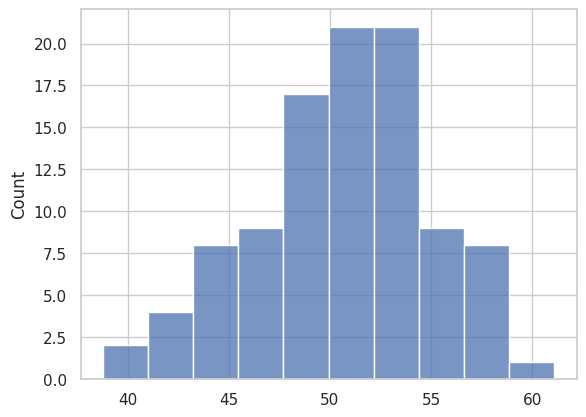

In [2]:
data = 5 * randn(100) + 50
sns.histplot(data)


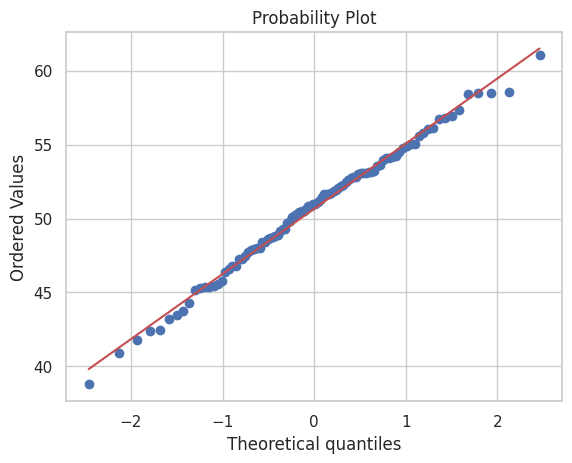

In [3]:
# Нарисуем квантильный график
stats.probplot(data, dist="norm", plot=plt)
plt.show()

In [4]:
# Проверим на нормальность 
stat, p = shapiro(data)
print('Statistics=%3.f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample doesnt look Normal (reject H0)')

Statistics=  1, p=0.875
Sample looks Normal (fail to reject H0)


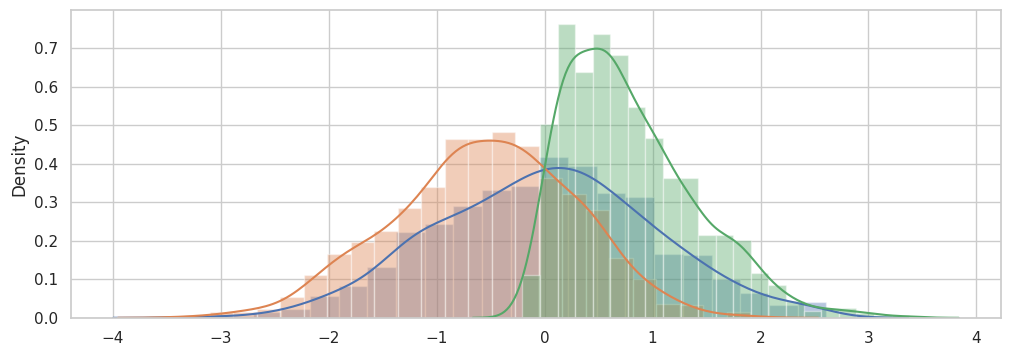

In [5]:
NUM_SAMPLES = 1000
SKEW_PARAMS = [0, -1, 10]

def randn_skew_fast(N, alpha=0.0, loc=0.0, scale=1.0):
    sigma = alpha / np.sqrt(1.0 + alpha**2) 
    u0 = np.random.randn(N)
    v = np.random.randn(N)
    u1 = (sigma*u0 + np.sqrt(1.0 - sigma**2)*v) * scale
    u1[u0 < 0] *= -1
    u1 = u1 + loc
    return u1

plt.subplots(figsize=(12,4))
for alpha_skew in SKEW_PARAMS:
    p = randn_skew_fast(NUM_SAMPLES, alpha_skew)
    sns.distplot(p)

In [6]:
# Посмотрим на квантильный график для скошенного распределения

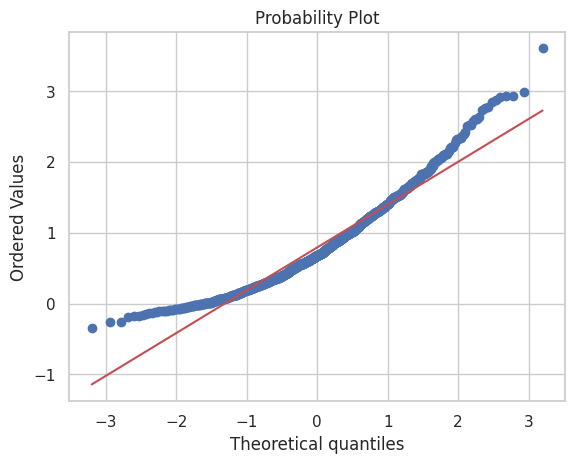

In [7]:
stats.probplot(randn_skew_fast(1000, 7), dist="norm", plot=plt)
plt.show()

## 1.2 Проверка на нормальность с помощью статистических критериев


In [9]:
def define_normality(stat, p, alpha=0.05):
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Sample looks Normal (fail to reject H0)')
    else:
        print('Sample doesnt look Normal (reject H0)')

In [10]:
skewed_sample = randn_skew_fast(1000, 1)

# Проверим слегка скошенное распределение на нормальность тремя критериями

print('shapiro')
stat, p = shapiro(skewed_sample)
define_normality(stat, p)
# code here

print('jarque')
# code here
stat, p = stats.jarque_bera(skewed_sample)
define_normality(stat, p)

print('ktest')
#code here
stat, p = stats.kstest(skewed_sample, 'norm')
define_normality(stat, p)


shapiro
Statistics=0.999, p=0.834
Sample looks Normal (fail to reject H0)
jarque
Statistics=0.565, p=0.754
Sample looks Normal (fail to reject H0)
ktest
Statistics=0.259, p=0.000
Sample doesnt look Normal (reject H0)


# 2. Сравнение параметров двух выборок

## 2.1 Независимые выборки

В файле **data/weight-height-sample.csv** содержатся данные роста и веса для мальчиков и девочек. Необходимо проверить гипотезу однородности мальчиков и девочек.

__Гипотеза:__ 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm} \text{Средние равны} \\
&H_1: \hspace{2mm} \mu_1 \ne \mu_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

In [18]:
wh_data = pd.read_csv('data/weight-height-sample.csv', sep=',')

In [19]:
wh_data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [20]:
len(wh_data)

2000

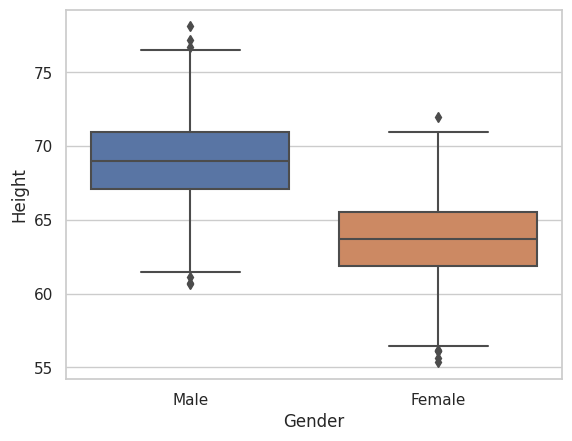

In [21]:
ax = sns.boxplot(x="Gender", y="Height", data=wh_data)

### Критерий Стьюдента ($t$-тест)

Мы еще изучали параметрические критерии Стьюдента для независимых выборок (Z-критерий и t-критерий). Эти критерии проверяют гипотезу о равенстве средних двух нормальных распределений против любой альтернативы. Z-критерий мы не будем рассматривать, так как для него необходимо знать дисперсию (которая никогда не является известной). А t-критерий частично реализован с помощью функции $\mathrm{ttest\_ind}$:

* <code>stats.ttest_ind(sample1, sample2, equal_var)</code> — t-критерий для независимых выборок. Тут $\mathrm{sample1}$ и $\mathrm{sample2}$ — реализации первой и второй выборки, а $\mathrm{equal\_var}$ булевая переменная, которая связана с предположением равенства дисперсии. По умолчанию она принимает значение True, но лучше использовать False, чтобы запускался аппроксимационный критерий (Уэлча), а не точный (Стьюдента).

Различные альтернативы, к сожалению, пока не реализованы. 

Конечно, перед применением критерия Стьюдента необходимо проверить нормальность данных.

In [28]:
sample1 = wh_data[wh_data['Gender'] == 'Male']['Height'].to_numpy()
sample2 = wh_data[wh_data['Gender'] == 'Female']['Height'].to_numpy()

<Axes: ylabel='Density'>

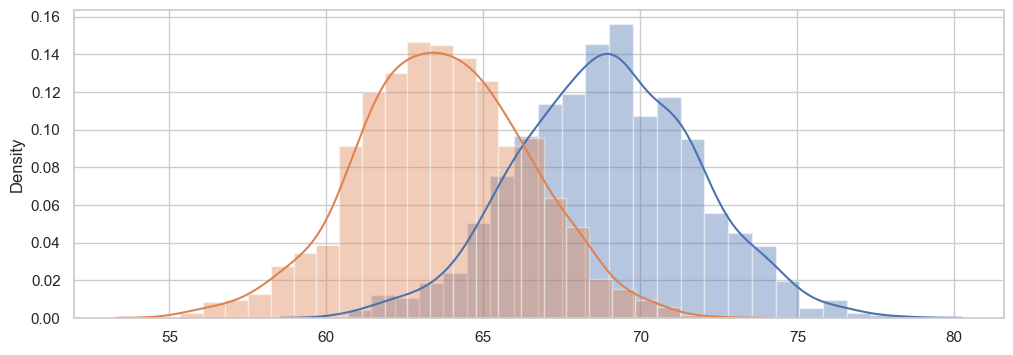

In [29]:
# нарисуем гистограммы
plt.subplots(figsize=(12,4))
sns.distplot(sample1)
sns.distplot(sample2)


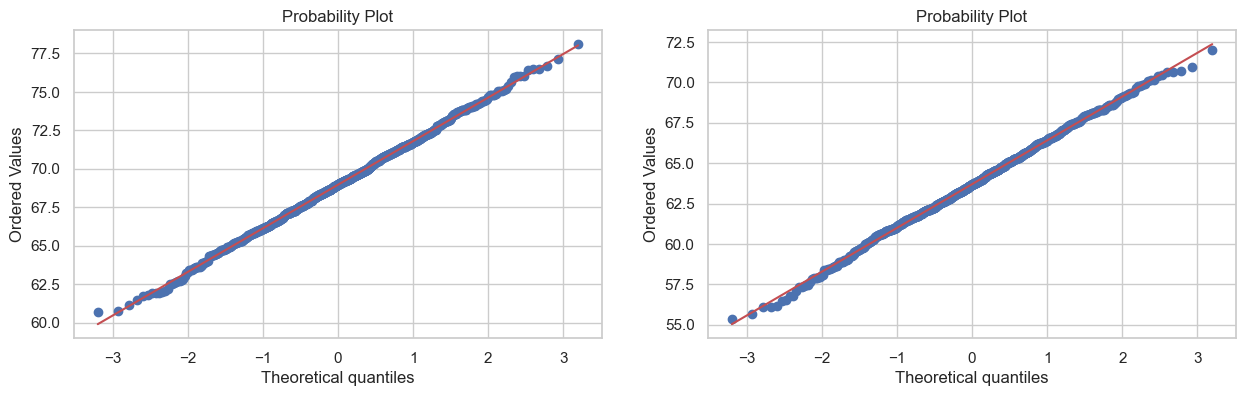

In [30]:
# посмотрим на квантильные графики

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4)) 

stats.probplot(sample1, dist='norm', plot=ax1)
stats.probplot(sample2, dist='norm', plot=ax2)

plt.show()

In [32]:
# проверим нормальность с помощью критерия Шапиро-Уилка
stat1, p1 = shapiro(sample1)
stat2, p2 = shapiro(sample2)

define_normality(stat1, p1)

define_normality(stat2, p2)

Statistics=0.999, p=0.894
Sample looks Normal (fail to reject H0)
Statistics=0.999, p=0.667
Sample looks Normal (fail to reject H0)


In [34]:
# проверим нормальность с помощью критерия Харке-Бера

stat1, p1 = stats.jarque_bera(sample1)
stat2, p2 = stats.jarque_bera(sample2)

define_normality(stat1, p1)

define_normality(stat2, p2)

Statistics=0.090, p=0.956
Sample looks Normal (fail to reject H0)
Statistics=0.257, p=0.880
Sample looks Normal (fail to reject H0)


In [35]:
stats.ttest_ind(sample1, sample2, equal_var=False)

TtestResult(statistic=42.52138791607131, pvalue=9.080161110147145e-282, df=1994.0325324951816)

In [37]:
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=910564.0, pvalue=7.794234866533963e-222)


## 2.2 Зависимые выборки 

В случае, когда выборки зависимы, мы должны использовать для проверки гипотез критерии, которые это учитывают.

In [25]:
stats.ttest_rel(sample1, sample2)

TtestResult(statistic=41.762566853110215, pvalue=2.401314135709455e-221, df=999)

### Пример 1. Реклама

Фокус-группу из потенциальных покупателей спрашивают, купят ли они товар. После им показывают 30 секундный видео-ролик, в котором объясняется как этот товар поменяет их жизнь. Каждого из них снова спрашивают, купит ли он товар. Нужно проверить гипотезу о том, что ролик повлиял на мнение людей. 

В таблице ниже в столбик записаны результаты первого опроса, в строчку результаты второго. 

In [70]:
df = pd.DataFrame([[30, 15], [9,51]])
df.columns = ['yes', 'no']
df.index = ['yes', 'no']
df

,yes,no
yes,30,15
no,9,51


In [71]:
df2 = pd.DataFrame([['a', 'b'], ['c', 'd']])
df2.columns = ['yes', 'no']
df2.index = ['yes', 'no']
df2

,yes,no
yes,a,b
no,c,d


__Гипотеза:__ 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{Ролик никак не повиял на готовность купить товар} \\
&H_1: \hspace{2mm} p_1 \ne p_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

__Критерий:__

$$
Z = \frac{c - b}{\sqrt{c + b - \frac{(c-b)^2}{n}}}
$$

In [75]:
def proportions_diff_z_stat_rel(df):
    n = df.sum().sum()  
    c = df.loc['no', 'yes']
    b = df.loc['yes', 'no']
    return (c-b) / np.sqrt( c +b - (c-b)**2 /n)

In [76]:
df

,yes,no
yes,30,15
no,9,51


In [77]:
z_obs = proportions_diff_z_stat_rel(df)
z_obs

-1.2335879094879223

In [79]:
alpha = 0.05
z_crit = stats.norm.ppf(alpha/2)
z_crit

-1.9599639845400545

In [80]:
print(f'Наблюдаемое значение {z_obs:.3} больше критического {z_crit:.3} => нулевая гипотеза не отвергается')

Наблюдаемое значение -1.23 больше критического -1.96 => нулевая гипотеза не отвергается


### Пример 2. Контрольная работа

В файле `cr.csv` лежат результеты контрольной работы. Подгрузим файлик и посмотрим на него!  

In [48]:
df = pd.read_csv('data/cr.tsv', sep='\t')
df.head()

,contest_login,fraud,k1a,k1b,k1c,k1d,k1e,k1f,k1,k2a,k2b,k2c,k2d,k2e,k2f,k2,k3a,k3b,k3c,k3
0,eds_python_2020_1,0.0,10.0,10.0,20.0,30.0,4.0,22.0,10.1,20.0,10.0,20.0,20.0,20.0,20.0,11.0,35.0,0.0,27.0,6.2
1,eds_python_2020_2,1.0,9.0,10.0,20.0,NaN,16.0,12.0,6.7,NaN,5.0,NaN,20.0,20.0,20.0,6.5,35.0,29.0,22.0,8.6
2,eds_python_2020_3,0.0,2.0,10.0,20.0,NaN,20.0,30.0,8.2,20.0,5.0,NaN,20.0,20.0,20.0,8.5,28.0,2.0,0.0,3.0
3,eds_python_2020_4,1.0,10.0,10.0,20.0,NaN,16.0,14.0,7.0,20.0,10.0,NaN,20.0,20.0,20.0,9.0,30.0,38.0,0.0,6.8
4,eds_python_2020_5,2.0,10.0,10.0,12.0,0.0,16.0,22.0,7.0,20.0,10.0,NaN,20.0,20.0,20.0,9.0,0.0,0.0,0.0,0.0


__Описание колонок:__


* `contest_login` - уникальный идентификатор студента
* `fraud` - в списывании скольки задач был уличён студент 
* `k1` - результат за первую контрольную, `k1a - k1f` в разбивке по задачам
* `k2` - результат за вторую контрольную, `k2a - k2f` в разбивке по задачам
* `k3` - результат за третью контрольную, `k3a - k3с` в разбивке по задачам

Правда ли, что в среднем их успеваемость не изменилась?

In [55]:
x = df.k3.fillna(0)
y = df.k1.fillna(0)

<Axes: xlabel='k1', ylabel='Density'>

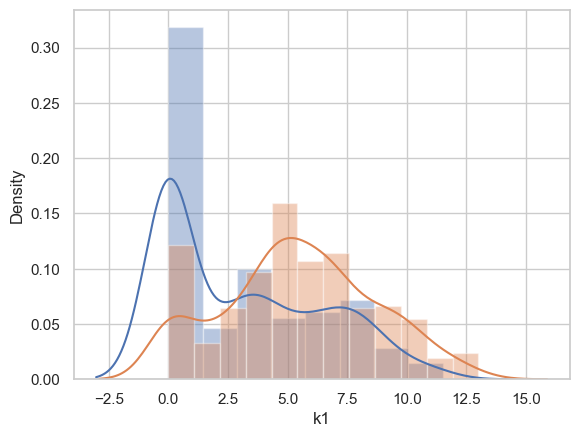

In [56]:
sns.distplot(x)
sns.distplot(y)

<Axes: ylabel='Density'>

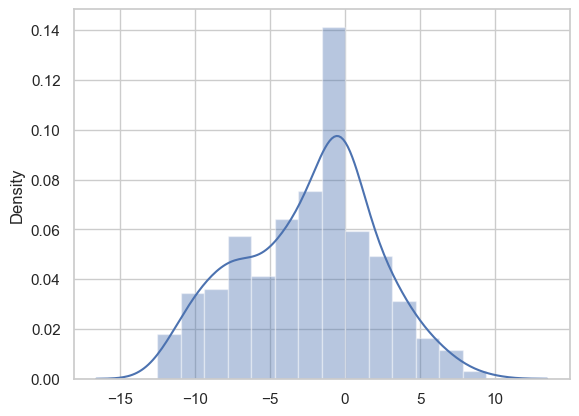

In [64]:
sns.distplot(x-y)

In [58]:
stat, p = shapiro(x)
define_normality(stat, p)


stat, p = shapiro(y)
define_normality(stat, p)

stat, p = shapiro(x-y)
define_normality(stat, p)

Statistics=0.840, p=0.000
Sample doesnt look Normal (reject H0)
Statistics=0.976, p=0.000
Sample doesnt look Normal (reject H0)
Statistics=0.983, p=0.000
Sample doesnt look Normal (reject H0)


In [59]:
stats.wilcoxon(x, y)

WilcoxonResult(statistic=14316.5, pvalue=9.7856848337872e-20)

In [65]:
# тест для зависимых выборок 
x = df.k3.fillna(0)
y = df.k1.fillna(0)

stats.wilcoxon(x, y, alternative='less')

WilcoxonResult(statistic=14316.5, pvalue=4.8928424168936e-20)

## 2.3 Независимые выборки 


Вы аналитик в онлайн-магазине который продает телефоны. Вы провели эксперимент (А/В тест), в котором изменили систему рекомендаций, вы ожидаете что средний чек покупки телефонов и аксессуаров после изменения увеличится.

На данном этапе мы опустим детали о проведении АБ тестов, в дальнейшем мы еще вернемся к этому примеру в рамках разговора об экспериментах. Но сейчас у вас есть просто две независимые группы пользователей - control и pilot, которые совершали покупки телефонов и аксессуаров на вашем сайте. Вы хотите проверить гипотезу о том, что средний чек покупки группы pilot больше чем группы control. 

In [35]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name, index_col=0)

In [38]:
exp_data = read_database('sem2_task1.csv')
exp_data['cost_total'] = exp_data['cost_phones'] + exp_data['cost_cases'] + exp_data['cost_accessories'] 
exp_data.head()

,day,cost_phones,cost_cases,cost_accessories,group,cost_total
0,1,21900,2300,3300,control,27500
1,1,43400,0,0,control,43400
2,1,31500,0,0,control,31500
3,1,31000,0,0,control,31000
4,1,50400,2300,5100,control,57800


Посмотрим на средний чек покупки в каждой группе

In [39]:
exp_data.groupby('group').agg({'cost_total': 'mean'})

,cost_total
group,
control,38957.456829
pilot,39311.447811


In [41]:
sample_a = exp_data[exp_data['group']=='control']['cost_total']
sample_b = exp_data[exp_data['group']=='pilot']['cost_total']

Средний чек на группе pilot действительно выше, давайте проверим статзначима ли эта разница. Для начала проверим распределения на нормальность.

<AxesSubplot:xlabel='cost_total', ylabel='Density'>

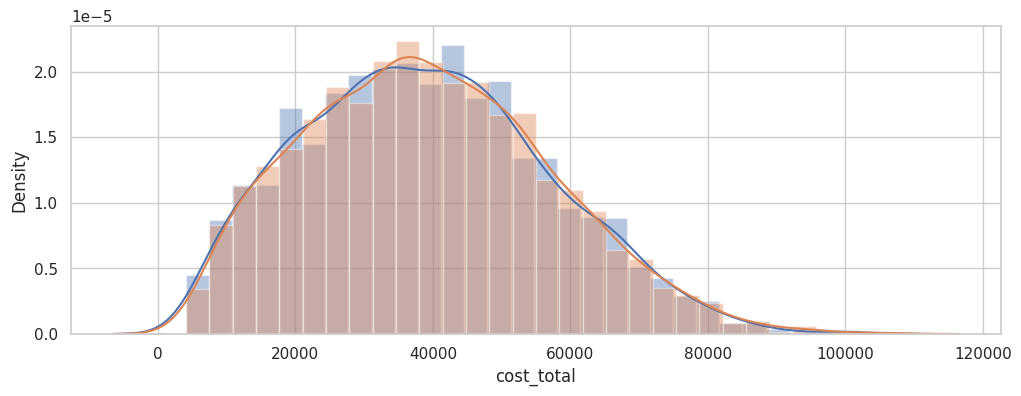

In [47]:
# нарисуем гистограммы
plt.subplots(figsize=(12,4))
sns.distplot(sample_a)
sns.distplot(sample_b)


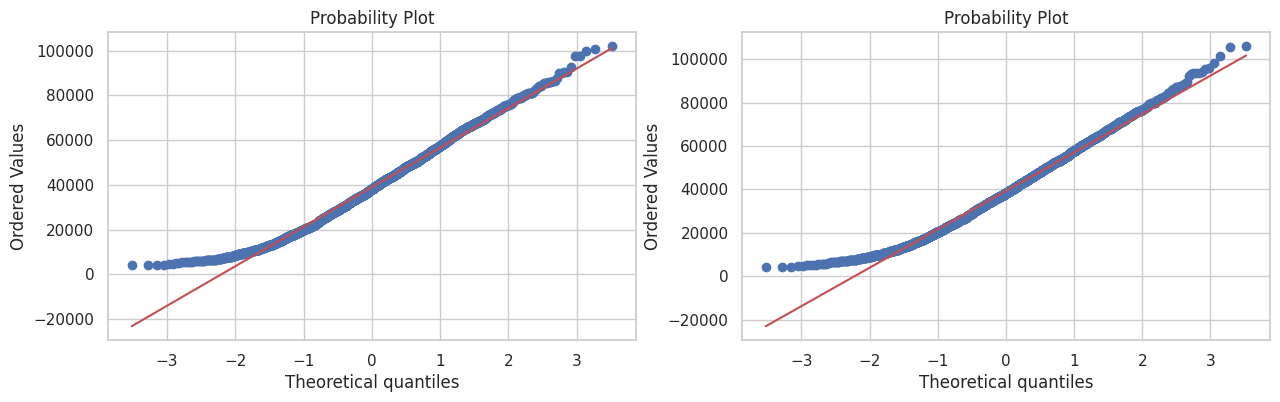

In [44]:
# посмотрим на квантильные графики

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4)) 

stats.probplot(sample_a, dist='norm', plot=ax1)
stats.probplot(sample_b, dist='norm', plot=ax2)

plt.show()

На квантильных графиках виден явный скос, поэтому давайте проверим на нормальность с помощью критерия Харке-Бера

In [48]:
# проверим нормальность с помощью критерия Харке-Бера

stat1, p1 = stats.jarque_bera(sample_a)
stat2, p2 = stats.jarque_bera(sample_b)

define_normality(stat1, p1)

define_normality(stat2, p2)

Statistics=69.530, p=0.000
Sample doesnt look Normal (reject H0)
Statistics=74.115, p=0.000
Sample doesnt look Normal (reject H0)


Распределения не являются нормальными, при этом выборки независимы (мы имеем разные группы пользователей), поэтому воспользуемся криетрием Манна-Уитни для проверки гипотезы о том, что суммарная стоимость чека увиличилась. 

In [52]:
u_stat, pvalue = stats.mannwhitneyu(sample_a, sample_b, alternative='less')
if  pvalue < 0.05:
    print(f'p_value = {pvalue:.3} => Отличие значимо (отвергаем нулевую гипотезу)')
else: 
    print(f'p_value = {pvalue:.3} => Отличие не стат.значимо (не отвергаем нулевую гипотезу)')


p_value = 0.239 => Отличие не стат.значимо (не отвергаем нулевую гипотезу)
